In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
    
tf.__version__


1 Physical GPUs, 1 Logical GPUs


'2.5.0'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
file_writer = tf.summary.create_file_writer('discover-tb-logs')

In [4]:
data_dir = "data/classifier_data"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/[0-9a-zA-Z]*.jpg')))
print(image_count)

425


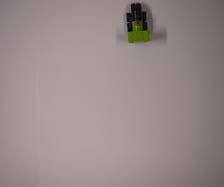

In [5]:
trains = list(data_dir.glob('train/[0-9a-zA-Z]*.jpg'))
PIL.Image.open(str(trains[0]))


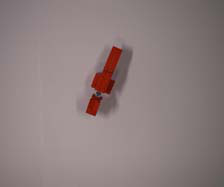

In [6]:
dinosaurs = list(data_dir.glob('dinosaur/[0-9a-zA-Z]*.jpg'))
PIL.Image.open(str(dinosaurs[0]))

In [7]:
batch_size = 32
img_height = 168
img_width = 224

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 425 files belonging to 2 classes.
Using 340 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 425 files belonging to 2 classes.
Using 85 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['dinosaur', 'train']


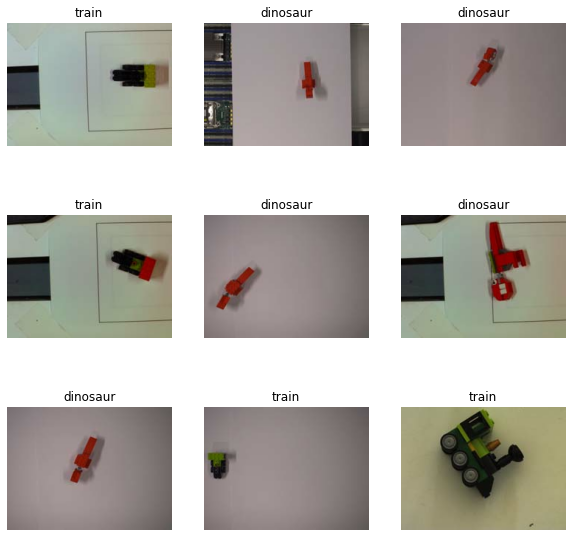

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 168, 224, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [16]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 168, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 168, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 168, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 112, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 112, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 56, 64)       

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 4s 69ms/step - loss: 0.8339 - accuracy: 0.5118 - val_loss: 0.6926 - val_accuracy: 0.5176
Epoch 2/10
11/11 [==============================] - 0s 32ms/step - loss: 0.6915 - accuracy: 0.5147 - val_loss: 0.6890 - val_accuracy: 0.5176
Epoch 3/10
11/11 [==============================] - 0s 24ms/step - loss: 0.6851 - accuracy: 0.5324 - val_loss: 0.7189 - val_accuracy: 0.5176
Epoch 4/10
11/11 [==============================] - 0s 23ms/step - loss: 0.6937 - accuracy: 0.4912 - val_loss: 0.6785 - val_accuracy: 0.7059
Epoch 5/10
11/11 [==============================] - 0s 23ms/step - loss: 0.5499 - accuracy: 0.8176 - val_loss: 0.3299 - val_accuracy: 0.8588
Epoch 6/10
11/11 [==============================] - 0s 24ms/step - loss: 0.2590 - accuracy: 0.8971 - val_loss: 0.2042 - val_accuracy: 0.8471
Epoch 7/10
11/11 [==============================] - 0s 24ms/step - loss: 0.1509 - accuracy: 0.9618 - val_loss: 0.0769 - val_accuracy: 0.9882
Epoch 8/10
11

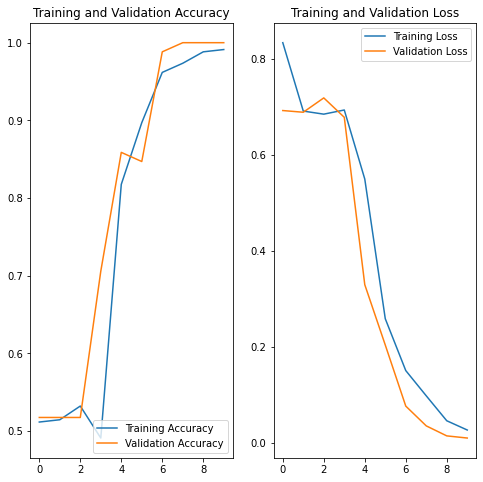

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
!rm .keras/datasets/*
train_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRJ3qa3FATqOcQWwS2HM9hyo5dAoUiy-QlEh3JhHRPPotnIKS8Qg8eHApV2e7QNL4aqTnU&usqp=CAU"
train_path = tf.keras.utils.get_file('Lego_train1', origin=train_url)

img = keras.preprocessing.image.load_img(
    train_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


rm: cannot remove '.keras/datasets/*': No such file or directory
This image most likely belongs to train with a 100.00 percent confidence.


In [22]:
dino_url = "https://www.lego.com/cdn/cs/set/assets/bltada8670c2144acf7/11001_BI_1HY19_Touts_dino.jpg?fit=crop&format=jpg&quality=80&width=800&height=426&dpr=1"
dino_path = tf.keras.utils.get_file('Lego_dino1', origin=dino_url)

img = keras.preprocessing.image.load_img(
    dino_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to dinosaur with a 100.00 percent confidence.


In [23]:
modeldir='model'
os.makedirs(modeldir, exist_ok=True)

dinotrain_save_path = os.path.join(modeldir, "dinotrain/1/")
tf.keras.models.save_model(model, dinotrain_save_path)

INFO:tensorflow:Assets written to: model/dinotrain/1/assets


In [24]:
!saved_model_cli show --all --dir model/dinotrain/1/

2021-06-01 14:02:46.190902: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sequential_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 168, 224, 3)
        name: serving_default_sequential_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method na

In [25]:
outputdir='model/trt'
os.makedirs(outputdir, exist_ok=True)


from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode='FP32')


In [26]:
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir=dinotrain_save_path,
    conversion_params=conversion_params)

INFO:tensorflow:Linked TensorRT version: (7, 2, 2)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 2)


In [27]:
converter.convert()

<ConcreteFunction pruned(sequential_input) at 0x7F3ED906F0B8>

In [28]:
converter.save(outputdir)

INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: model/trt/assets


In [29]:
loaded = tf.saved_model.load(dinotrain_save_path)
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

['serving_default']
{'dense_1': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_1')}
